<a href="https://colab.research.google.com/github/Fonzy0508/Clustering-Distribution-Visualization-learning/blob/main/Visualizing_Cluster_VanillaAN_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Visualization of Latent Embeddings with Fashion-MNIST Class Labels**
 **Purpose of the Visualization:**

This visualization presents the latent embeddings extracted from an Autoencoder trained on the Fashion-MNIST dataset. The embeddings are processed using different dimensionality reduction techniques (like t-SNE or UMAP) and clustering algorithms (such as K-Means, DBSCAN, and HDBSCAN) to explore how the Autoencoder has captured the underlying data patterns.



In [1]:
# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Data Manipulation and Visualization
import numpy as np
import matplotlib.pyplot as plt

# Dimensionality Reduction & Clustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


# **Loaded the Data sets of DIfferent wearables from tensorflow datasets**

In [2]:
# Load the Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Print dataset shapes
print(f"Training data shape: {x_train.shape}, Labels: {y_train.shape}")
print(f"Test data shape: {x_test.shape}, Labels: {y_test.shape}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (60000, 28, 28), Labels: (60000,)
Test data shape: (10000, 28, 28), Labels: (10000,)


# **Visualize 10 Random data from the dataset**

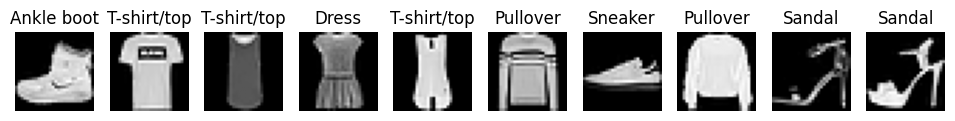

In [3]:
import matplotlib.pyplot as plt

# Class names for reference
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Function to plot sample images
def plot_sample_images(images, labels, class_names, num_images=10):
    plt.figure(figsize=(12, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.show()

# Visualize 10 sample images
plot_sample_images(x_train, y_train, class_names)

# **Flatten our Data to process in the Auto-encoders**

In [4]:
## Checks if what normalization is needed
print(f"Min pixel value: {x_train.min()}")
print(f"Max pixel value: {x_train.max()}")

Min pixel value: 0
Max pixel value: 255


Since 255 is the max pixel for the training data, to get the normalization it should be divided by **255.0**

In [5]:
# Normalize pixel values to range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

Since our dataset of pictures have all of 28x28 sizes of image

We flattened this mostly because we are using Vanila autoencoders which requires 1d data

In [6]:
# Flatten images (28x28 -> 784)
x_train_flat = x_train.reshape((len(x_train), 28 * 28))
x_test_flat = x_test.reshape((len(x_test), 28 * 28))

# Check shapes after preprocessing
print(f"Training data shape after flattening: {x_train_flat.shape}")
print(f"Test data shape after flattening: {x_test_flat.shape}")

Training data shape after flattening: (60000, 784)
Test data shape after flattening: (10000, 784)


# **Get Flattened data ready top be given to Vanilla Autoencoder**


*   **input_dim** - flattened pixels into 1d (28x28 = 784)
*   **endocing_dim** - this controls the compression value in the latent space. Value  of this tells how general or spot on an autoencoder can be in the output (lower value means more general | higher means more accurate and spot on)



In [53]:
# Import TensorFlow/Keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Define dimensions
input_dim = 784  # Flattened image size (28x28 pixels)
encoding_dim = 128  # Latent space dimension


# **Setting up Vanilla Autoencoder**


*   **Dense** - Layers in Nueral network
 *   **128 ** - Number of nuerals where flattened data will go through
 * **Activation** - Layers where handles how data in nueral will be processed
  ** **Relu** - only takes positive data, then disregards negative data(Takes important features only)
  ** **sigmoid** - ensures data in output is balanced


*  Adam optimizer - A smart optimizer that automatically adjusts the learning rate during training.
* Binary Crossentropy - It calculates how well the model is doing by treating each pixel as a probability (since we normalized the data).





In [58]:
# Input layer
input_img = Input(shape=(input_dim,))

# Encoder
encoded = Dense(256, activation='relu')(input_img) ## learns basic pattern
encoded = Dense(128, activation='relu')(encoded) ## learns basic pattern
encoded = Dense(encoding_dim, activation='relu')(encoded)  # reduces data into the latent space(embeddings)

# Decoder
decoded = Dense(128, activation='relu')(encoded) # Mirrors the encoder to reconstruct the image back to its original size
decoded = Dense(256, activation='relu')(decoded) # Mirrors the encoder to reconstruct the image back to its original size
decoded = Dense(input_dim, activation='sigmoid')(decoded)  # Output layer (Ensures pixel values are between 0 and 1, matching the normalized input.)

# Build Autoencoder
autoencoder = Model(input_img, decoded)

# Encoder model (for extracting embeddings later)
encoder = Model(input_img, encoded)

# Compile Autoencoder
autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

# Print model summary
autoencoder.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 784)                 │         201,488 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 501,392 (1.91 MB)

 Trainable params: 501,392 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

# **Training The Vanila Autoencoder**

*   **input** - What the Autoencoder analyzes
*   **input** - What the Autoencoder tries to reproduce.
*   **epoch** - How many the model will re iterate or re analyze the whole dataset
*   **batch_size** - how many samples the model processes at once
*   **shuffle** - it shuffles the training data before each epoch to improve learning.
* **validation_data** - it Used as the test set to monitor validation loss and check if the model is overfitting.



In [59]:
# Train the Autoencoder
history = autoencoder.fit(
    x_train_flat,                #input
    x_train_flat,                #target
    epochs=20,                   # Number of training epochs
    batch_size=256,              # Batch size
    shuffle=True,                # Shuffle the data for better training
    validation_data=(x_test_flat, x_test_flat)  # Use test data for validation
)


Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.4322 - val_loss: 0.3109
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.3054 - val_loss: 0.2984
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.2948 - val_loss: 0.2922
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 0.2898 - val_loss: 0.2880
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.2850 - val_loss: 0.2855
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.2820 - val_loss: 0.2835
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.2800 - val_loss: 0.2817
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.2788 - val_loss: 0.2799
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.2779 - val_loss: 0.2788
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.2760 - val_loss: 0.2778
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.2750 - val_loss: 0.2768
Epoch 12/20
235/235 ━━━━━━━━━━━━━━━

# **Understanding the Training output**
* **loss** - The training loss.(The less the better)
* **val_loss** - The validation loss (using unseen data from the test set).

# **Visualizing the Difference of the input data and output data**
**Things to consider**

*   If the input data is still recongnizable to the output data

If reconstructions are too blurry,we need to:
*  Increase the latent space size (e.g., from 64 to 128).
* Use more complex models like Convolutional Autoencoders (which we can try later!).




313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


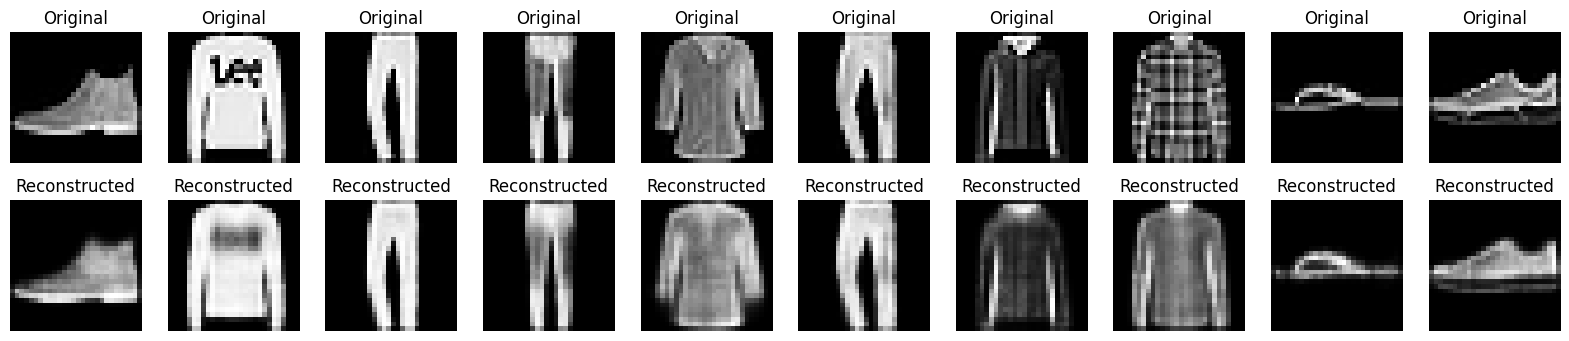

In [60]:
# Function to plot original vs reconstructed images
def plot_reconstructed_images(original, reconstructed, num_images=10):
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Original images
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed images
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.show()

# Use the trained Autoencoder to reconstruct images
reconstructed_imgs = autoencoder.predict(x_test_flat)

# Plot original vs reconstructed images
plot_reconstructed_images(x_test_flat, reconstructed_imgs)

# **Using t-NSE dimension reduction to visualize embedings**
t-SNE reduces the 64D embeddings to 2D
* **perplexity** - balances focus between local and global clusters.
* **learning_rate** - controls how fast t-SNE adjusts during optimization.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Latent embeddings shape: (10000, 128)
t-SNE reduced shape: (10000, 2)


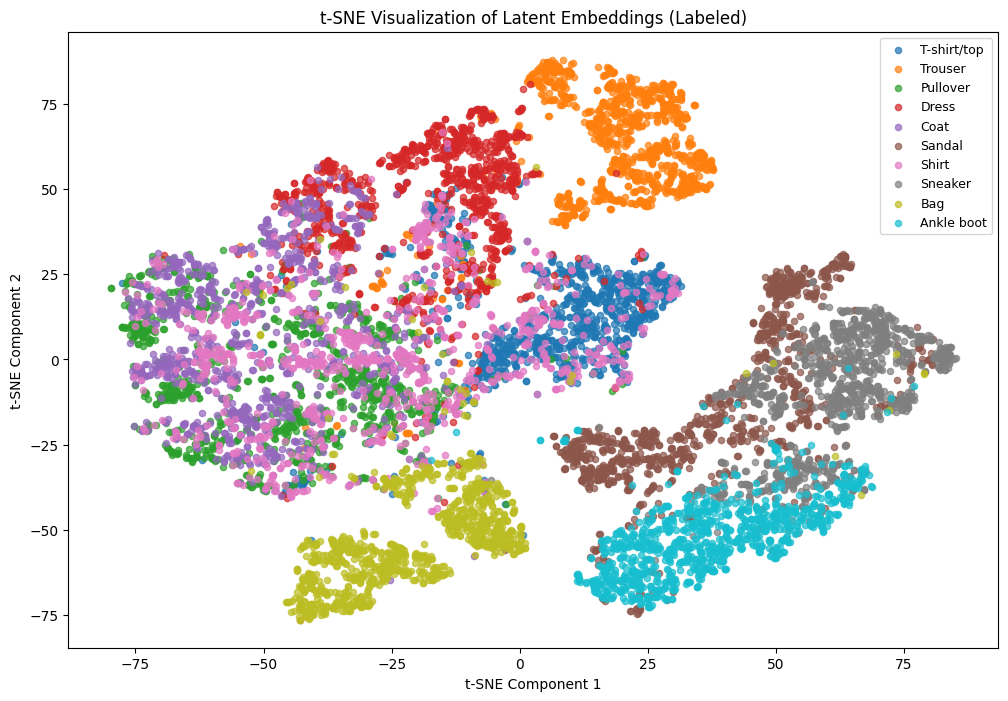

In [61]:
# Use the encoder to extract latent embeddings from the test set
latent_embeddings = encoder.predict(x_test_flat)

# Check the shape of the embeddings
print(f"Latent embeddings shape: {latent_embeddings.shape}")

# Import t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to reduce 64D embeddings to 2D
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(latent_embeddings)

# Check the shape after t-SNE
print(f"t-SNE reduced shape: {X_tsne.shape}")

# Load test labels
(_, y_test) = fashion_mnist.load_data()[1]

# Map numerical labels to class names
mapped_labels = [class_names[label] for label in y_test]

# Plot t-SNE with actual class names
plt.figure(figsize=(12, 8))

# Create a scatter plot for each class
for i, class_name in enumerate(class_names):
    idx = np.where(y_test == i)
    plt.scatter(
        X_tsne[idx, 0],
        X_tsne[idx, 1],
        label=class_name,
        alpha=0.7,
        s=20
    )

plt.legend(loc="best", fontsize=9)
plt.title("t-SNE Visualization of Latent Embeddings (Labeled)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


# **Using PCA to reduce dimension(2d) of embeddings then K-means algo to visualize**

**Reducing Dimension using PCA**

Reduces 64D latent embeddings to 2D using PCA for visualization.

PCA reduced shape: (10000, 2)


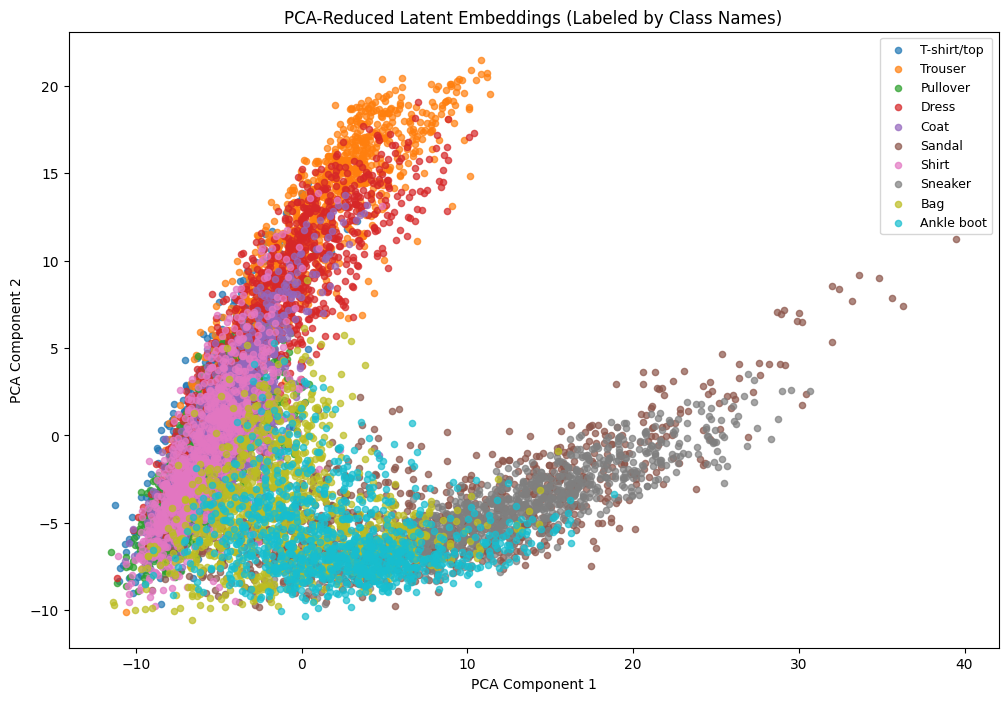

In [62]:
# Apply PCA to reduce from 64D to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(latent_embeddings)

# Check the shape after PCA
print(f"PCA reduced shape: {X_pca.shape}")
# Map true labels to class names
mapped_labels = [class_names[label] for label in y_test]

# Plot PCA-reduced data with class names
plt.figure(figsize=(12, 8))

# Create a scatter plot for each class
for i, class_name in enumerate(class_names):
    idx = np.where(y_test == i)
    plt.scatter(
        X_pca[idx, 0],
        X_pca[idx, 1],
        label=class_name,
        alpha=0.7,
        s=20
    )

plt.legend(loc="best", fontsize=9)
plt.title("PCA-Reduced Latent Embeddings (Labeled by Class Names)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

**Used K-means Cluster Algorigthm to help us visualize**

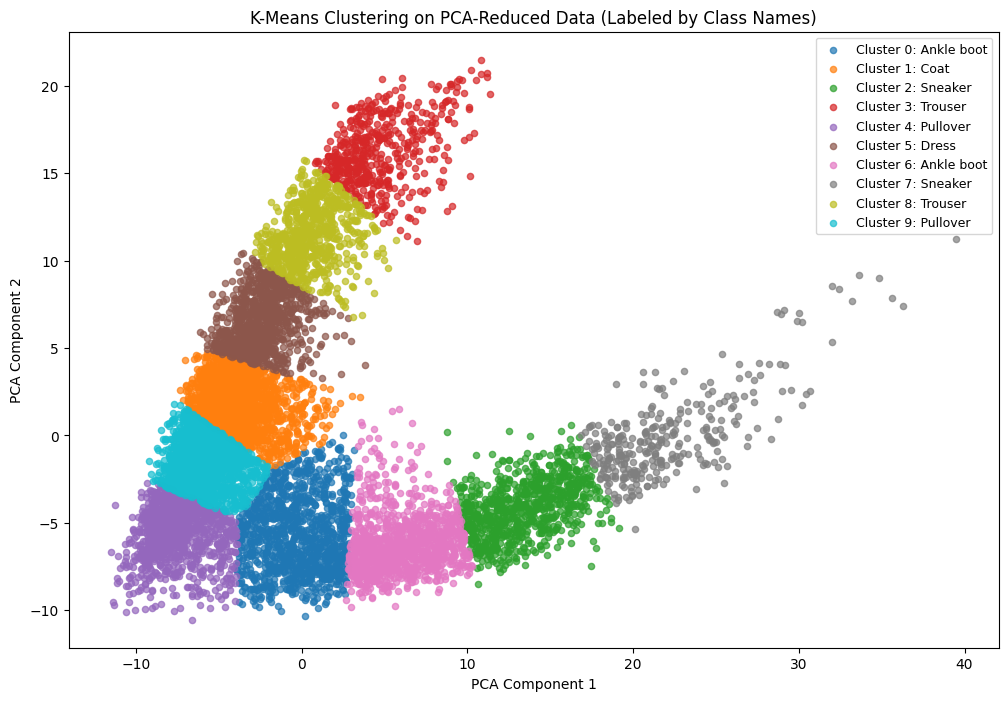

In [63]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

# Map K-Means clusters to the most common class in each cluster
cluster_labels = {}
for i in range(10):
    cluster_indices = np.where(kmeans_labels == i)
    common_class = Counter(y_test[cluster_indices]).most_common(1)[0][0]
    cluster_labels[i] = class_names[common_class]

# Plot K-Means clusters with mapped labels
plt.figure(figsize=(12, 8))
for i in range(10):
    idx = np.where(kmeans_labels == i)
    plt.scatter(
        X_pca[idx, 0],
        X_pca[idx, 1],
        label=f"Cluster {i}: {cluster_labels[i]}",
        alpha=0.7,
        s=20
    )

plt.legend(loc="best", fontsize=9)
plt.title("K-Means Clustering on PCA-Reduced Data (Labeled by Class Names)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


# **Reduced by PCA then used t-NSE for Visualization**

**Applied PCA reducted dimension but only for 30demension only**

In [64]:
# Apply PCA to reduce from 64D to 30D
pca_30 = PCA(n_components=30)
latent_pca_30 = pca_30.fit_transform(latent_embeddings)

# Check shape after PCA
print(f"PCA reduced shape: {latent_pca_30.shape}")

PCA reduced shape: (10000, 30)


**Apply t-SNE on 30d PCA-Reduced Data**

In [65]:
# Apply t-SNE to reduce from 30D to 2D
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne_from_pca = tsne.fit_transform(latent_pca_30)

# Check shape after t-SNE
print(f"t-SNE reduced shape: {X_tsne_from_pca.shape}")

t-SNE reduced shape: (10000, 2)


**t-NSE Cluster Visualization from 30d reduced PCA**

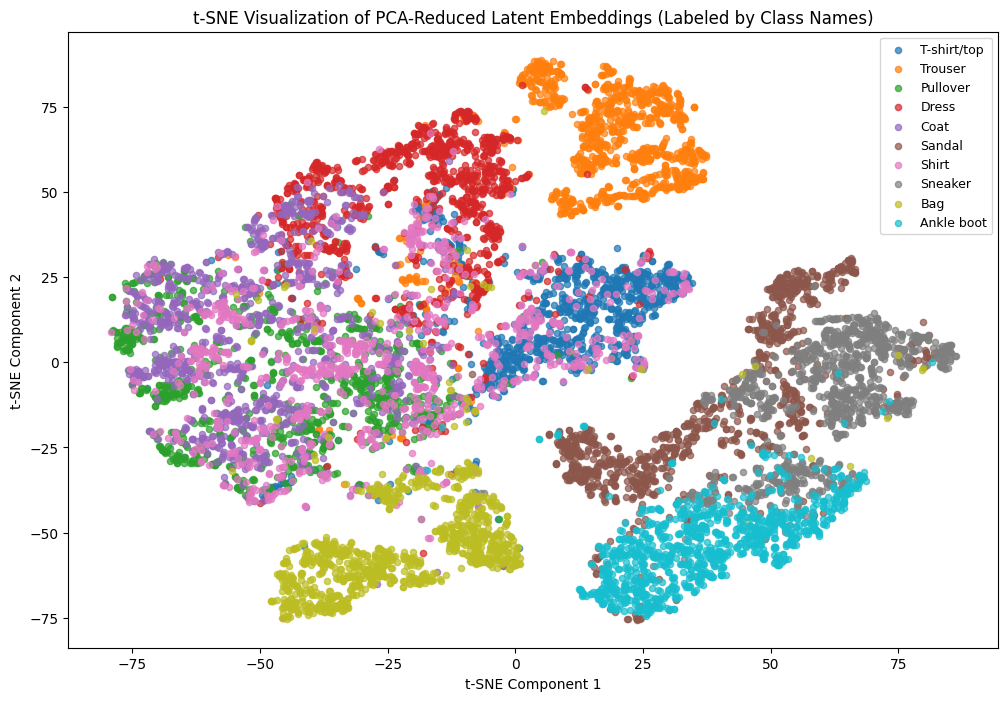

In [66]:
# Plot t-SNE results with class names
plt.figure(figsize=(12, 8))

# Plot each class separately
for i, class_name in enumerate(class_names):
    idx = np.where(y_test == i)
    plt.scatter(
        X_tsne_from_pca[idx, 0],
        X_tsne_from_pca[idx, 1],
        label=class_name,
        alpha=0.7,
        s=20
    )

plt.legend(loc="best", fontsize=9)
plt.title("t-SNE Visualization of PCA-Reduced Latent Embeddings (Labeled by Class Names)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# **use UMAP to the latent embeddings and visualize the results**

In [25]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.3 MB/s eta 0:00:00


In [67]:
#Import UMAP lib
import umap

# Apply UMAP to reduce from 64D to 2D
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(latent_embeddings)

# Check shape after UMAP
print(f"UMAP reduced shape: {X_umap.shape}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP reduced shape: (10000, 2)


UMAP Cluster Visualization

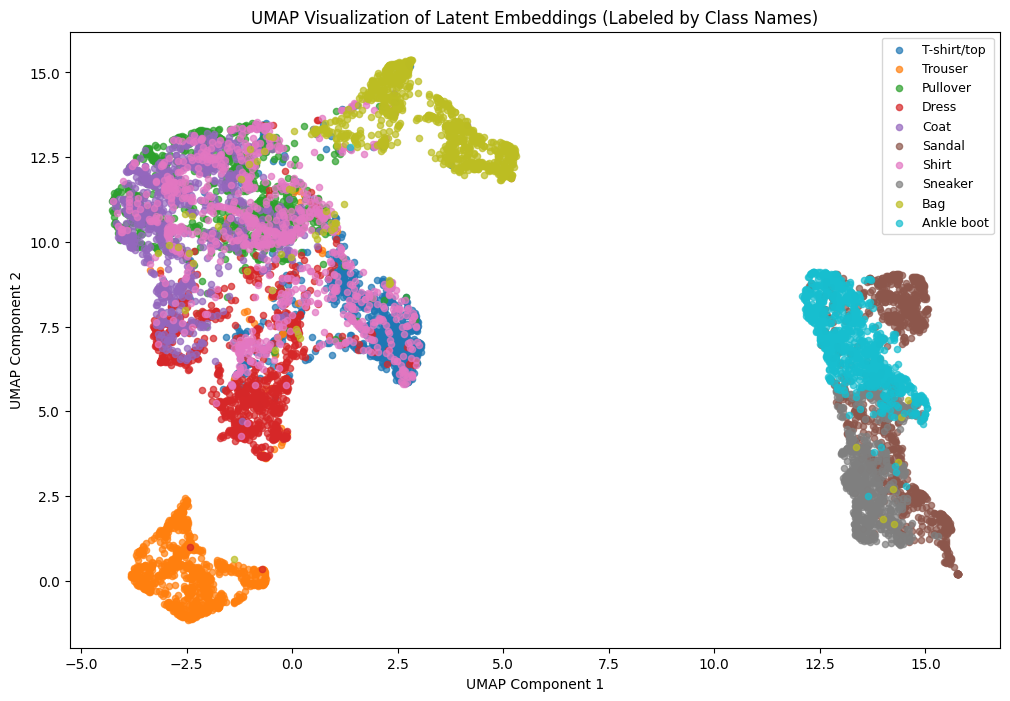

In [68]:
# Plot UMAP results with class names
plt.figure(figsize=(12, 8))

# Plot each class separately
for i, class_name in enumerate(class_names):
    idx = np.where(y_test == i)
    plt.scatter(
        X_umap[idx, 0],
        X_umap[idx, 1],
        label=class_name,
        alpha=0.7,
        s=20
    )

plt.legend(loc="best", fontsize=9)
plt.title("UMAP Visualization of Latent Embeddings (Labeled by Class Names)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

Applying DBSCAN for UMAP

*   Adjust **eps** - lower eps Leads to more clusters and fewer merges.



In [69]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Apply DBSCAN to UMAP-reduced data
dbscan = DBSCAN(eps=0.2, min_samples=5)  # You can tune eps and min_samples
dbscan_labels = dbscan.fit_predict(X_umap)

# Count unique clusters (DBSCAN labels noise points as -1)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")

# Calculate Silhouette Score (excluding noise points)
if n_clusters > 1:
    score = silhouette_score(X_umap[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
    print(f"Silhouette Score for DBSCAN: {score:.2f}")
else:
    print("Not enough clusters to compute Silhouette Score.")

Estimated number of clusters: 7
Estimated number of noise points: 59
Silhouette Score for DBSCAN: 0.20


Visualize DBSCAN cluster from UMAP reduced data

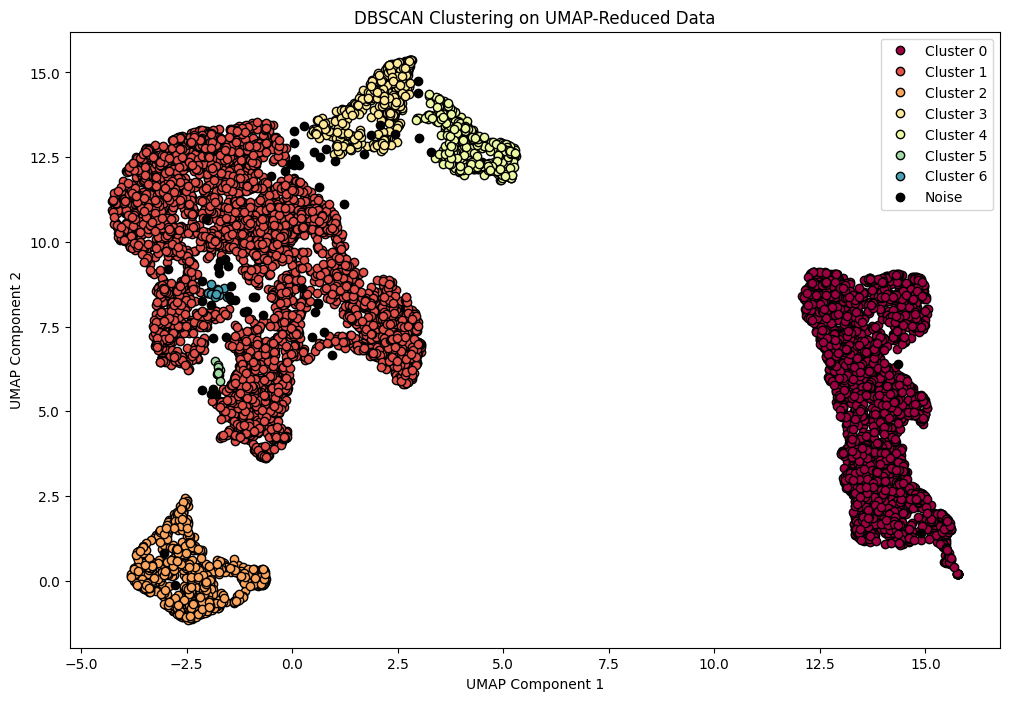

In [70]:
# Plot DBSCAN clusters on UMAP-reduced data
plt.figure(figsize=(12, 8))

# Assign colors: -1 (noise) will be plotted in black
unique_labels = set(dbscan_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for label, col in zip(unique_labels, colors):
    if label == -1:
        # Black for noise points
        col = [0, 0, 0, 1]
        label_name = 'Noise'
    else:
        label_name = f'Cluster {label}'

    class_member_mask = (dbscan_labels == label)
    xy = X_umap[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6, label=label_name)

plt.title("DBSCAN Clustering on UMAP-Reduced Data")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(loc="best")
plt.show()

Apply HDBSCAN for the UMAP Reduced data

In [44]:
!pip install hdbscan


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 73.0 MB/s eta 0:00:00


**Setting up HDBSCAN**

Key HDBSCAN Parameters:





*   min_cluster_size → Minimum number of points to form a cluster.
*   min_samples → Similar to DBSCAN, controls how "dense" a region must be to form a cluster.
*   cluster_selection_epsilon → Defines how much separation is required between clusters.



In [71]:
#import
import hdbscan
# Apply HDBSCAN
hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=10, cluster_selection_epsilon=0.1)
hdbscan_labels = hdbscan_cluster.fit_predict(X_umap)

# Count unique clusters (HDBSCAN labels noise points as -1)
n_clusters = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
n_noise = list(hdbscan_labels).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Estimated number of clusters: 8
Estimated number of noise points: 93


**Visualize HDBSCAN from UMAP reduced data**

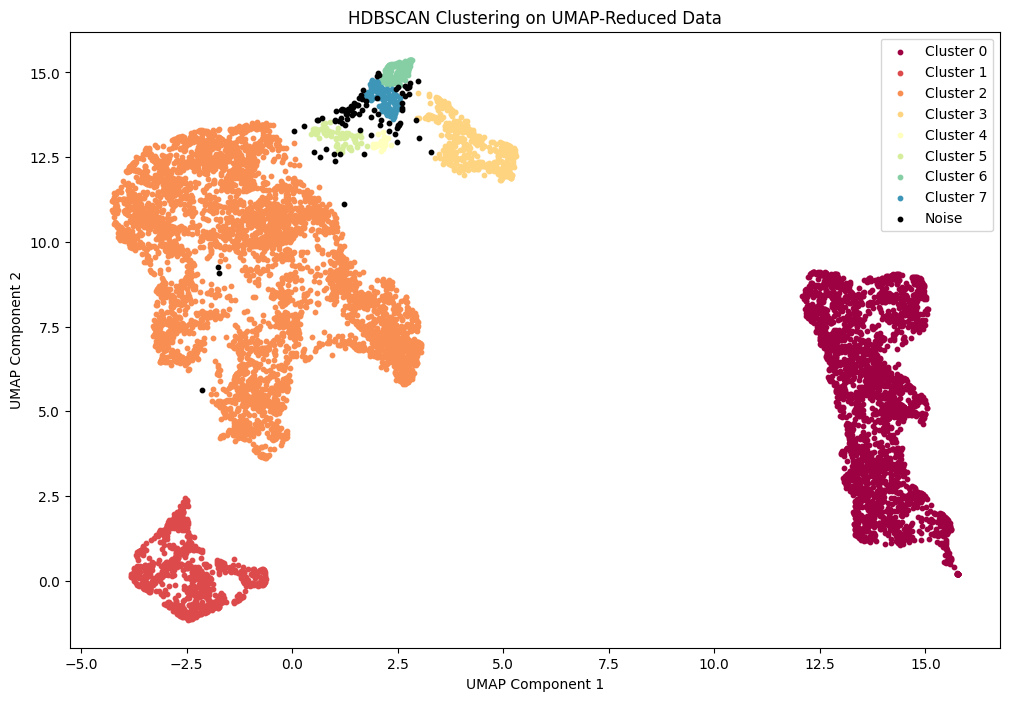

In [72]:
# Plot HDBSCAN clusters on UMAP-reduced data
plt.figure(figsize=(12, 8))

# Assign colors: -1 (noise) will be plotted in black
unique_labels = set(hdbscan_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for label, col in zip(unique_labels, colors):
    if label == -1:
        # Black for noise points
        col = [0, 0, 0, 1]
        label_name = 'Noise'
    else:
        label_name = f'Cluster {label}'

    class_member_mask = (hdbscan_labels == label)
    xy = X_umap[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[col], label=label_name, s=10)

plt.title("HDBSCAN Clustering on UMAP-Reduced Data")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(loc="best")
plt.show()
